<a href="https://colab.research.google.com/github/NanaseSAITOH/DialogueBot/blob/feature%2F2LayerLSTM/seq2seqJapanese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データ準備

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

import pickle

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def load_data() :
    %cd /content/drive/My Drive/Colab Notebooks/002_seq2seq_single_layer
    #単語ファイルロード
    with open('words.pickle', 'rb') as ff :
        words=pickle.load(ff)         

    #Encoder Inputデータをロード
    with open('train_encoder.pickle', 'rb') as f :
        encoder = pickle.load(f)

    #Decoder Inputデータをロード
    with open('train_decoder.pickle', 'rb') as g :
        decoder = pickle.load(g)

    #ラベルデータをロード
    with open('label.pickle', 'rb') as h :
        label = pickle.load(h)

    #maxlenロード
    with open('maxlen.pickle', 'rb') as maxlen :
        [maxlen_e, maxlen_d] = pickle.load(maxlen)

    #id2word
    with open('indices2word.pickle', 'rb') as i2w :
        indices2word = pickle.load(i2w)

    #word2id
    with open('word2indices.pickle', 'rb') as w2i :
        word2indices = pickle.load(w2i)

    print(word2indices["　"])
    row = encoder.shape[0]

    encoder = encoder.reshape((row, maxlen_e))
    decoder = decoder.reshape((row, maxlen_d))
    label = label.reshape((row, maxlen_d))

    data = {
            'encoder'           :encoder,
            'decoder'           :decoder,
            'label'           :label,
            'maxlen_e'    :maxlen_e,
            'maxlen_d'    :maxlen_d,
            'indices2word' : indices2word,
            'word2indices' : word2indices,
            'input_dim'   : len(words),
            'output_dim'  : len(words)
            }
    return data

In [ ]:
dataset = load_data()
maxlen_e     = dataset['maxlen_e']
maxlen_d     = dataset['maxlen_d']
encoder            = dataset['encoder']
decoder            = dataset['decoder']
label            = dataset['label'] 
indices2word = dataset['indices2word'] 
word2indices = dataset['word2indices'] 
data_row     = encoder.shape[0]                  # 訓練データの行数
n_split      = int(data_row*0.9)           # データの分割比率
# データを訓練用とテスト用に分割
encoder_train, encoder_test = np.vsplit(encoder,[n_split])   #エンコーダインプット分割
decoder_train, decoder_test = np.vsplit(decoder,[n_split])   #デコーダインプット分割
label_train, label_test = np.vsplit(label,[n_split])   #ラベルデータ分割
print(len(label_train))
#train_dataset

/content/drive/My Drive/Colab Notebooks/002_seq2seq_single_layer
7
53311


In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# データをバッチ化するための関数
def train2batch(input_data, output_data, batch_size):
    input_batch = []
    output_batch = []
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_data[i:i+batch_size])
      output_batch.append(output_data[i:i+batch_size])
    return input_batch, output_batch

## NN定義

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


embedding_dim = 300 # 文字の埋め込み次元数
hidden_dim = 256 # LSTMの隠れ層のサイズ
vocab_size = 10169 # 扱う文字の数。今回は１３文字

# GPU使う用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = 2)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # Many to Oneなので、第２戻り値を使う
        _, state = self.lstm(embedding)
        # state = (h, c)
        return state

In [ ]:
# Decoderクラス
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = 2)
        # LSTMの128次元の隠れ層を13次元に変換する全結合層
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sequence, encoder_state):
        embedding = self.word_embeddings(sequence)
        # Many to Manyなので、第１戻り値を使う。
        # 第２戻り値は推論時に次の文字を生成するときに使います。
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state

In [ ]:
# GPU使えるように。
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

## 学習

In [115]:
BATCH_NUM = 32
EPOCH_NUM = 10

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0 # epoch毎のloss

    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(encoder_train, decoder_train, batch_size=BATCH_NUM)
    print(len(input_batch))
    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device, dtype=torch.long)
        output_tensor = torch.tensor(output_batch[i], device=device, dtype=torch.long)

        # Encoderの順伝搬
        encoder_state = encoder(input_tensor)

        # Decoderで使うデータはoutput_tensorを１つずらしたものを使う
        # Decoderのインプットとするデータ
        source = output_tensor[:, :-1]

        # Decoderの教師データ
        # 生成開始を表す"_"を削っている
        target = output_tensor[:, 1:]

        loss = 0
        # 学習時はDecoderはこのように１回呼び出すだけでグルっと系列をループしているからこれでOK
        # sourceが４文字なので、以下でLSTMが4回再帰的な処理してる
        decoder_output, _ = decoder(source, encoder_state)
        # decoder_output.size() = (100,4,13)
        # 「13」は生成すべき対象の文字が13文字あるから。decoder_outputの3要素目は
        # [-14.6240,  -3.7612, -11.0775,  ...,  -5.7391, -15.2419,  -8.6547]
        # こんな感じの値が入っており、これの最大値に対応するインデックスを予測文字とみなす

        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            # 生成する文字は4文字なので、4回ループ
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        # Encoder、Decoder両方学習
        encoder_optimizer.step()
        decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 1: break
print("Done")

training ...
1666
Epoch 1: 94186.92
1666
Epoch 2: 78557.02
1666
Epoch 3: 74823.22
1666
Epoch 4: 72132.31
1666
Epoch 5: 69882.66
1666
Epoch 6: 67571.29
1666
Epoch 7: 65408.41
1666
Epoch 8: 63218.13
1666
Epoch 9: 61096.48
1666
Epoch 10: 59139.15
Done


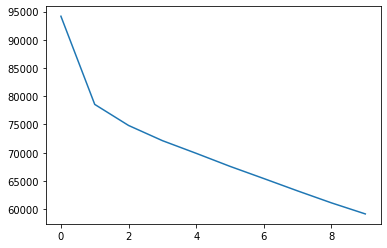

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

In [117]:
torch.save(encoder.state_dict(), 'encoder.ckpt')
torch.save(decoder.state_dict(), 'decoder.ckpt')

## テスト評価

In [120]:
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)

In [125]:
input_batch, output_batch = train2batch(encoder_test, decoder_test, batch_size=BATCH_NUM)
print(len(input_batch))
with torch.no_grad(): # 勾配計算させない
    input_tensor = torch.tensor(input_batch[0], device=device, dtype=torch.long)
    encoder_state = encoder(input_tensor)

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[word2indices["SSSS"]] for _ in range(BATCH_NUM)]
    decoder_input = torch.tensor(start_char_batch, device=device, dtype=torch.long)

    # 変数名変換
    decoder_hidden = encoder_state

    # バッチ毎の結果を結合するための入れ物を定義
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    # (100,1)
    for i in range(50):
        print(indices2word[input_tensor[29][i].item()])

    for _ in range(5):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input = get_max_index(decoder_output.squeeze())
      print(indices2word[decoder_input[29][0].item()])
      # バッチ毎の結果を予測順に結合



186
なんか
ね
、
UNK
み
たい
の
が
。
日本
文学
だ
と
、
平安
の
方
は
多い
んだ
って
。
だけど
その分
。
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
うん
。
	
	
	
